# Land Use Changes

Changes in land use that result in increased density of households or jobs increase the number of opportunities accessible within a travel shed of the increase.

The land use change must be a single feature (may be a multipart polygon). 

The cells below increase the number of households and jobs within overlapping TAZs. Increases may be a net change (total change from present day) or a percent increase. HH and Job increases are apportioned based the extent of the overlap.

A land use scenario may have an absolute change in the number of households and jobs or a percentage change. Either an absolute change or percentage change may be indicated.

Use the `multiply_hh` and `mutliply_job` variables to indicate a percent change. For example, a 50% reduction in households would be indicated with `multiply_hh=0.5` and a 33% increase in jobs as `multiply_job=1.33`.

In [48]:
# fill in scenario name and impacts first - then run cells below
scenario_name = "daybreak_commercial_1"
add_hh = 2950
add_job = 2400
multiply_hh = 1.0
multiply_job = 1.0

In [49]:
import sys
import os
import arcpy
import shutil

utm_12n = 'PROJCS["NAD_1983_UTM_Zone_12N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-111.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]];-5120900 -9998100 450445547.391054;-100000 10000;-100000 10000;0.001;0.001;0.001;IsHighPrecision'
base_path = os.path.abspath(".")

mode = "Land_Use"
target_gdb = os.path.join(base_path, "scenario", mode, scenario_name + ".gdb")

#if (add_hh + add_job != 0) and (multiply_hh + multiply_job != 2):
#    raise Exception('Specify an absolute change or percent change, but not both.')

In [50]:
# create scenario file geodatabase from template

# if target gdb exists, delete it
if os.path.isdir(target_gdb):
    shutil.rmtree(target_gdb)
    
# copy template
shutil.copytree(r"scenario\scenario_template.gdb", target_gdb)

arcpy.env.workspace = target_gdb

# Create temporary working layer for editing
   
arcpy.management.CreateFeatureclass(
    target_gdb, "land_use_mod", 
    "POLYGON", r'shp\land_use_template.gdb\land_use_empty', 
    "DISABLED", "DISABLED", utm_12n
)

ExecuteError: Failed to execute. Parameters are not valid.
ERROR 000732: Template Feature Class: Dataset shp\land_use_template.gdb\land_use_empty does not exist or is not supported
Failed to execute (CreateFeatureclass).


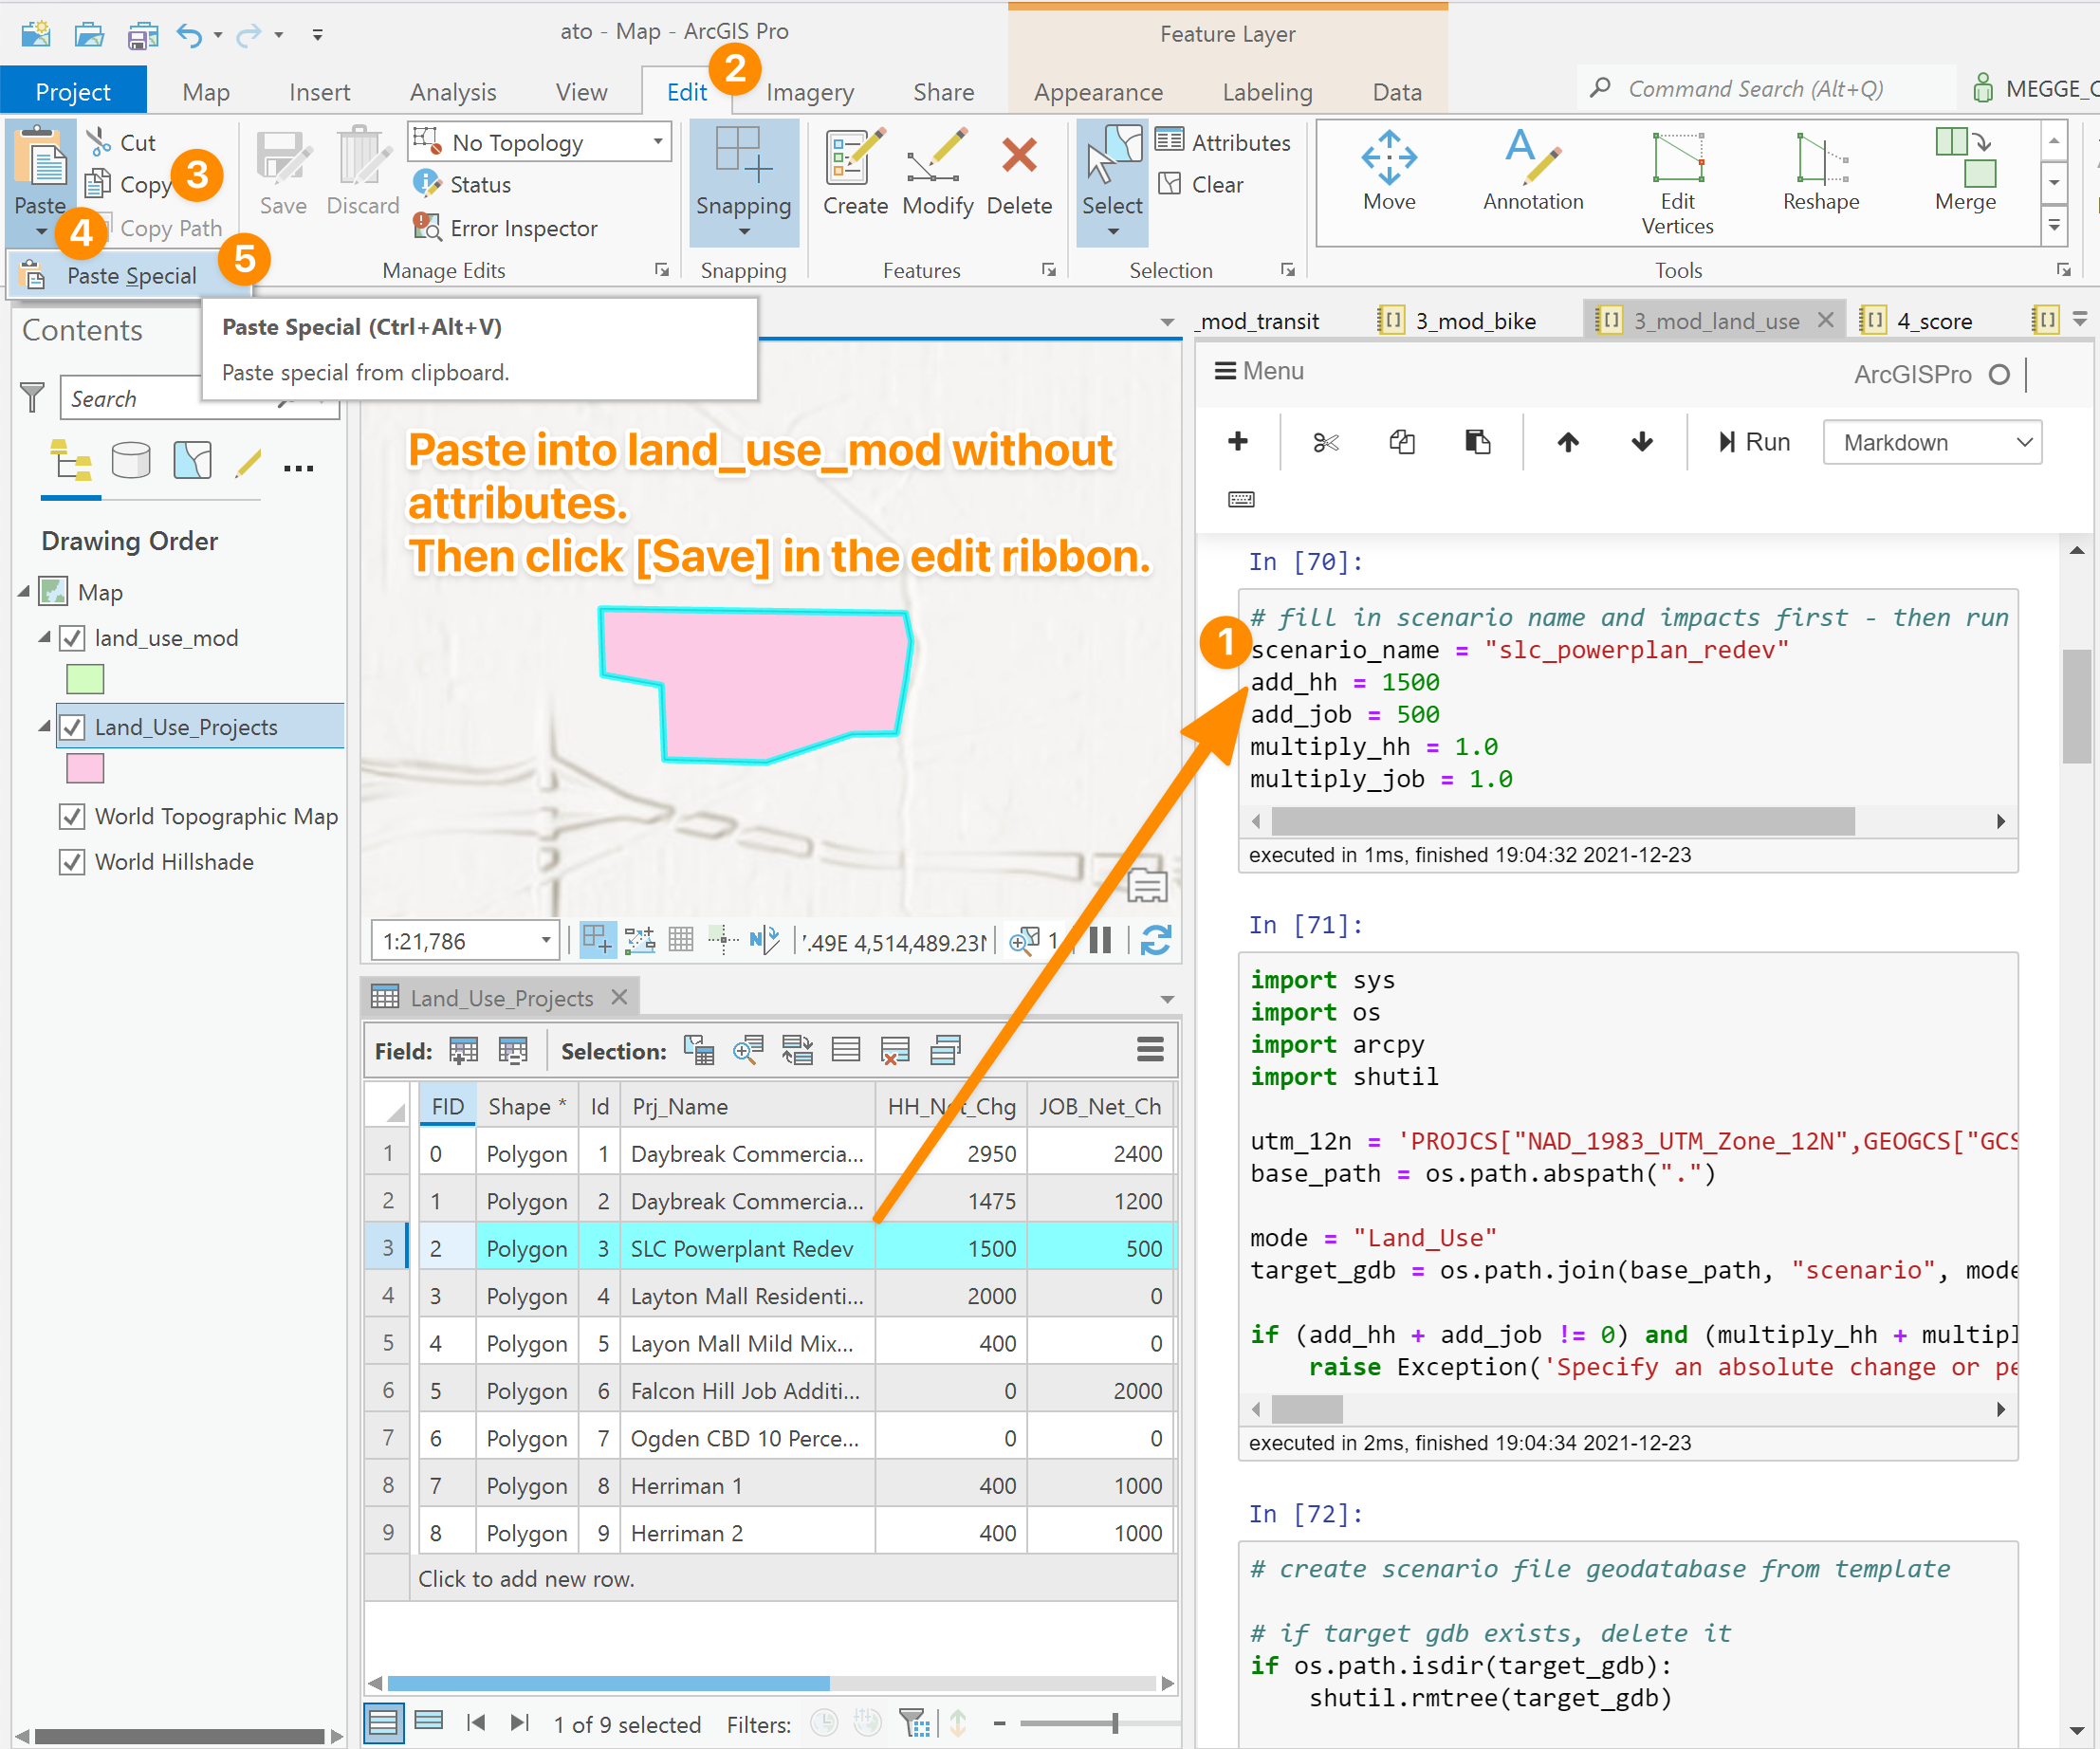

## Copy Feature

Copy the feature (one feature, singular--if multiple polygons are required, **dissolve** into a single feature) representing the land use change geography to the `land_use_mod` feature layer (Copy --> Paste Special. Paste into land_use_src layer and do not keep source attribute values). 

**Save your changes to  `land_use_mod`.**

(Note, the cell below will fail if the `land_use_mod layer` is still in "Edit" mode after pasting in the new feature.)

In [ ]:
# calculate area of land use change area for apportionment
arcpy.management.CalculateGeometryAttributes(
    "land_use_mod", "square_meters_land_use_polygon AREA", '', "SQUARE_METERS"
)

# Add TAZ layer to map for editing
arcpy.management.MakeFeatureLayer(
    r'baseline.gdb\taz',
    "TAZ"
)

# intersect TAZ geometries with land use polygon
arcpy.analysis.Intersect(
    "land_use_mod #;TAZ #", 
    os.path.join(target_gdb, "land_use_intersect"), 
    "ALL", None, "INPUT"
)

In [ ]:
# calculate % overlaps
arcpy.management.CalculateField(
    "land_use_intersect", 
    "land_use_pct_overlap", 
    '!Shape_Area! / !square_meters_land_use_polygon!', 
    "PYTHON3", None, "DOUBLE"
)
arcpy.management.CalculateField(
    "land_use_intersect", 
    "taz_pct_overlap", 
    '!Shape_Area! / !square_meters_taz!', 
    "PYTHON3", None, "DOUBLE"
)

In [ ]:
# update jobs and hh based on scenario input values

# Add TAZ layer to map for editing
arcpy.management.MakeTableView(
    os.path.join(target_gdb, "taz_table"),
    "taz_table"
)

arcpy.management.JoinField(
    "land_use_intersect", 
    "CO_TAZID", 
    "taz_table", 
    "CO_TAZID", 
    "HH;JOB"
)

arcpy.management.CalculateField(
    "land_use_intersect", 
    "HH_new", 
    '(({0}-1) * !taz_pct_overlap! * !HH!) + (!land_use_pct_overlap! * {1})'.format(multiply_hh, add_hh), 
    "PYTHON3", None, "DOUBLE"
)
arcpy.management.CalculateField(
    "land_use_intersect", 
    "JOB_new", 
    '(({0}-1) * !taz_pct_overlap! * !JOB!) + (!land_use_pct_overlap! * {1})'.format(multiply_job, add_job), 
    "PYTHON3", None, "DOUBLE"
)

In [ ]:
# copy new HH and JOB back to the taz_table
arcpy.management.JoinField(
    "taz_table", 
    "CO_TAZID", 
    "land_use_intersect", 
    "CO_TAZID", 
    "HH_new;JOB_new"
)

expr = 'round(!HH! + !HH_new!) if !HH_new! is not None else !HH!'
arcpy.management.CalculateField(
    "taz_table", 
    "HH", 
    expr, 
    "PYTHON3", None, "DOUBLE"
)

expr = 'round(!JOB! + !JOB_new!) if !JOB_new! is not None else !JOB!'
arcpy.management.CalculateField(
    "taz_table", 
    "JOB", 
    expr, 
    "PYTHON3", None, "DOUBLE"
)

In [ ]:
arcpy.management.DeleteField("taz_table", ['HH_new', 'JOB_new'])
# clean up map
aprx = arcpy.mp.ArcGISProject("CURRENT")
mp = aprx.listMaps("Map")[0]
for layer in mp.listLayers():
    if layer.name in ["TAZ", "land_use_mod", "land_use_intersect", "taz_table"]:
        mp.removeLayer(layer)
for table in mp.listTables():
    if table.name in ["taz_table"]:
        mp.removeTable(table)
        
arcpy.env.workspace = 'ato.gdb'

### note - there's some issue that when repeatedly creating land use projects that scores may repeat. Current workaround is to restart ArcGIS between each project.